In [1]:
from client_revised import Client
from server_by_GJL import Server
import matplotlib.pyplot as plt
import pandas as pd
import operator
from copy import deepcopy
from functools import reduce
import numpy as np
import gc

In [9]:
FILE_NUM = int(1e5)
TIMESTAMP_NUM = int(5e3)
client = Client(FILE_NUM, TIMESTAMP_NUM)

print('FILE_NUM', FILE_NUM)
print('TIMESTAMP_NUM', TIMESTAMP_NUM)
print('client.file_pool_size', client.file_pool_size)

server_hit_rate_with_attack_dict, attack_in_cache = {'N': None}, {}
# cache_size_array = [1e4, 2e4, 5e4, 1e5, 2e5, 5e5, 7.5e5, 1e6, 2e6, 3e6, 4e6, 5e6]
cache_size_array = [1e4, 2e4, 5e4, 1e5, 2e5, 5e5, 1e6, 2e6, 3e6, 4e6, 5e6]
print('\n' + '#' * 80 + '\n')

total_client_requests: 62489997
FILE_NUM 100000
TIMESTAMP_NUM 5000
client.file_pool_size 99584878

################################################################################



No handles with labels found to put in legend.


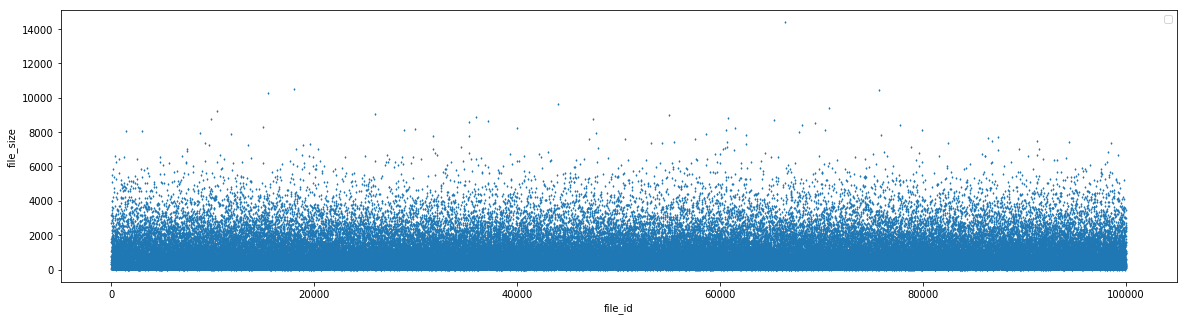

mean: 995.84878
median: 691.0


In [10]:
plt.figure(figsize=(20, 5))
fid_arr=[i.fid for i in client.file_pool]
size_arr=[i.size for i in client.file_pool]
plt.scatter(fid_arr,size_arr,s=1,marker='d')
plt.xlabel("file_id")
plt.ylabel("file_size")
plt.legend()
# plt.savefig("attack_in_cache_percentage.png")
plt.show()
print('mean:',np.mean(size_arr))
print('median:',np.median(size_arr))
# sum([int(i) for i in np.array(size_arr)<1000])

In [13]:
def attack(attack_level):
    server_hit_rate, server_hit_rate_with_attack, server_hit_rate_with_attack_ignore_attack = [], [], []
    client.__make_attack_trace__(attack_level)
    attack_in_cache[attack_level] = {}

    for cache_size in cache_size_array:
        gc.collect()
        if cache_size>client.file_pool_size: continue
        attack_in_cache_percentage_changes = []
        # two identical servers
        server = Server(cache_size, 'LRU')
        server_under_attack = deepcopy(server)

        if not server_hit_rate_with_attack_dict['N']:
            # just normal trace
            for time in range(client.num_of_time_stamps):
                for request_file in client.trace[time]:
                    server.handle(client.file_pool[request_file])
            server_hit_rate.append(server.hit_rate())
            print('normal:', 'cache_size:', cache_size, server_hit_rate[-1])

        for time in range(client.num_of_time_stamps):
            if time >= 0.05 * TIMESTAMP_NUM:  # 不知道该不该做此限制，一开始需要让server启动再开始攻击才有针对性
                client.__make_attack_trace_for_single_time_stamp__(server_under_attack.cache, time,
                                                                   client.num_attack_for_each_time_stamp[time],
                                                                   pattern='KCS', spy=server_under_attack.spy)
                server_under_attack.spy.clear()
            requests_in_timestamp = [(f, True) for f in client.trace[time]] + [(f, False) for f in
                                                                               client.attack_trace[time]]
            np.random.shuffle(requests_in_timestamp)
            for request_file in requests_in_timestamp:
                server_under_attack.handle(client.file_pool[request_file[0]], request_file[1])
            # 记录attack file占总cache size的比例
            attack_in_cache_percentage_changes.append(
                sum([client.file_pool[f].size for f in server_under_attack.attack_in_cache]) / cache_size)
        print('total_attack_requests:', sum([len(i) for i in client.attack_trace]))
        server_hit_rate_with_attack.append(server_under_attack.hit_rate())
        server_hit_rate_with_attack_ignore_attack.append(server_under_attack.hit_rate(ignore_attack=True))
        attack_in_cache[attack_level][cache_size] = attack_in_cache_percentage_changes
        print('attack:', attack_level, 'cache_size:', cache_size, server_hit_rate_with_attack[-1])
        print('attack:', attack_level + '_ignore_attack', 'cache_size:', cache_size,
              server_hit_rate_with_attack_ignore_attack[-1])
    if not server_hit_rate_with_attack_dict['N']:
        server_hit_rate_with_attack_dict['N'] = server_hit_rate
    server_hit_rate_with_attack_dict[attack_level] = server_hit_rate_with_attack
    server_hit_rate_with_attack_dict[attack_level + '_ignore_attack'] = server_hit_rate_with_attack_ignore_attack

In [14]:
attack_levels = {'H', 'M', 'L', 'LL'}  # 
for attack_level in attack_levels:
    attack(attack_level)
    gc.collect()

normal: cache_size: 10000.0 0.16306713856678426
total_attack_requests: 4826
attack: LL cache_size: 10000.0 0.16307248361735383
attack: LL_ignore_attack cache_size: 10000.0 0.1630850774378644
normal: cache_size: 20000.0 0.20256824463917691
total_attack_requests: 4826
attack: LL cache_size: 20000.0 0.20255295386303354
attack: LL_ignore_attack cache_size: 20000.0 0.20256858069296163
normal: cache_size: 50000.0 0.256253908921515
total_attack_requests: 4826
attack: LL cache_size: 50000.0 0.256235464491895
attack: LL_ignore_attack cache_size: 50000.0 0.2562552051289704
normal: cache_size: 100000.0 0.2904672727014138
total_attack_requests: 4826
attack: LL cache_size: 100000.0 0.29048436539630673
attack: LL_ignore_attack cache_size: 100000.0 0.2905066870095944
normal: cache_size: 200000.0 0.31580846450807465
total_attack_requests: 4826
attack: LL cache_size: 200000.0 0.3157956619812205
attack: LL_ignore_attack cache_size: 200000.0 0.31581990633931667
normal: cache_size: 500000.0 0.346707377816

In [18]:
df = pd.DataFrame.from_dict(server_hit_rate_with_attack_dict)
df.to_csv('./server_hit_rate_with_attack.csv')

In [17]:
df = pd.DataFrame.from_dict(attack_in_cache)
df.to_csv('./attack_in_cache.csv')

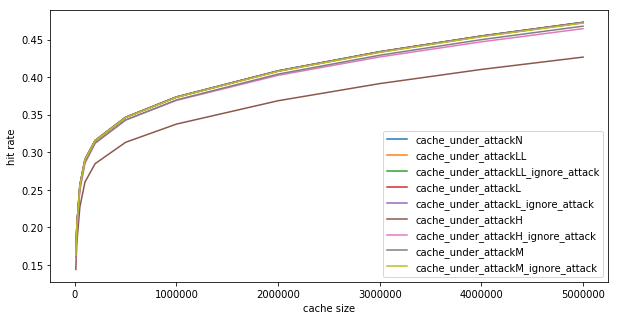

In [15]:
plt.figure(figsize=(10, 5))
for attack_level in server_hit_rate_with_attack_dict:
    plt.plot(cache_size_array, server_hit_rate_with_attack_dict[attack_level],
             label='cache_under_attack' + attack_level)
plt.xlabel("cache size")
plt.ylabel("hit rate")
plt.legend()
# plt.savefig("cache_under_attack_" + str(rdi) + ".png")
plt.show()

cache_under_attack10000.0LL 0.0004222799999999999
cache_under_attack20000.0LL 0.00040748999999999994
cache_under_attack50000.0LL 0.000269552
cache_under_attack100000.0LL 0.00030680199999999995
cache_under_attack200000.0LL 0.0003223450000000001
cache_under_attack500000.0LL 0.000242858
cache_under_attack1000000.0LL 0.0002402882
cache_under_attack2000000.0LL 0.00019971469999999997
cache_under_attack3000000.0LL 0.00018418233333333337
cache_under_attack4000000.0LL 0.000175414
cache_under_attack5000000.0LL 0.00017973675999999997
cache_under_attack10000.0L 0.00337546
cache_under_attack20000.0L 0.0038644099999999995
cache_under_attack50000.0L 0.003579384
cache_under_attack100000.0L 0.003795038
cache_under_attack200000.0L 0.0035515330000000004
cache_under_attack500000.0L 0.0031755584000000003
cache_under_attack1000000.0L 0.0028521194000000003
cache_under_attack2000000.0L 0.0024273792999999996
cache_under_attack3000000.0L 0.0022643786
cache_under_attack4000000.0L 0.0021777932999999996
cache_unde

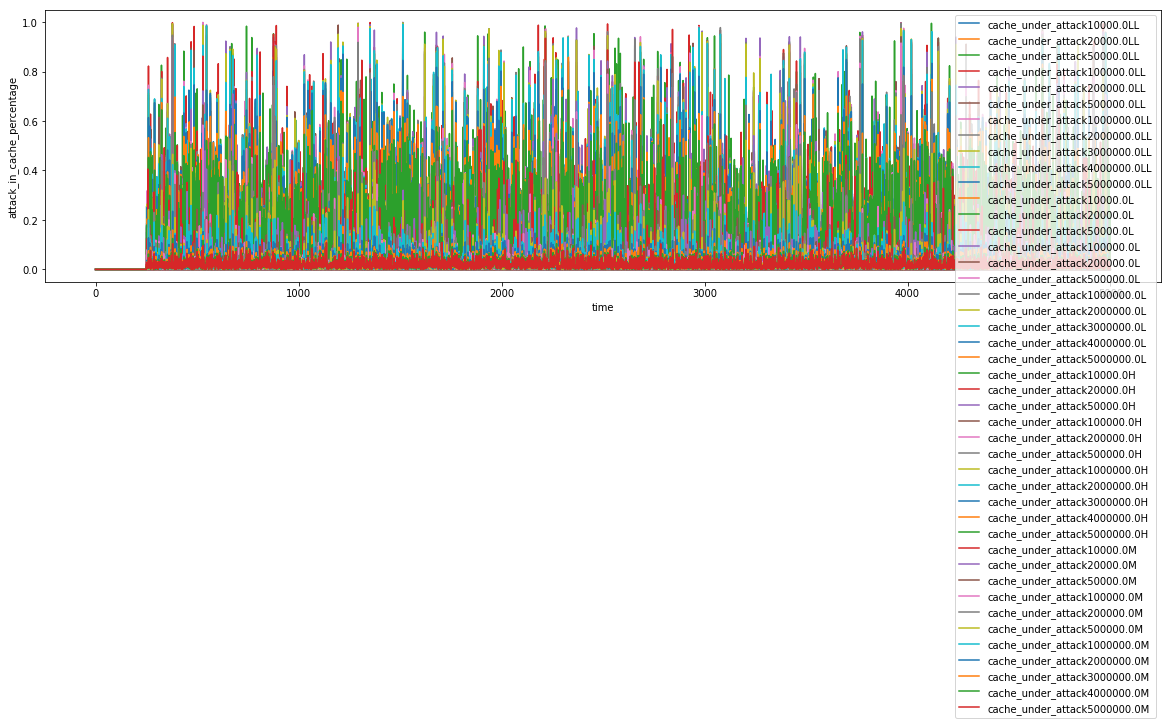

In [16]:
plt.figure(figsize=(20, 5))
for attack_level in attack_in_cache:
    for cache_size in attack_in_cache[attack_level]:
        t=attack_in_cache[attack_level][cache_size]
        print('cache_under_attack' + str(cache_size) + attack_level, np.mean(t))
        plt.plot(range(len(t)), t,
                 label='cache_under_attack' + str(cache_size) + attack_level)
plt.xlabel("time")
plt.ylabel("attack_in_cache_percentage")
plt.legend()
# plt.savefig("attack_in_cache_percentage.png")
plt.show()

In [21]:
len(client.trace)

5000